<a href="https://colab.research.google.com/github/mukilan2815/MLQUEST-Air-quality/blob/main/MLQUEST_AIR_QUALITY_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Comprehensive Air Quality Prediction using XGBoost**

# **Import necessary libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

# **Load and explore the data**

In [ ]:
print("Loading and exploring the data...")
df = pd.read_csv('/content/drive/MyDrive/ML QUEST/airquality/city_day.csv')
print(df.head())
print(df.info())

Loading and exploring the data...
        City        Date  PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2  \
0  Ahmedabad  2015-01-01    NaN   NaN   0.92  18.22  17.15  NaN   0.92  27.64   
1  Ahmedabad  2015-01-02    NaN   NaN   0.97  15.69  16.46  NaN   0.97  24.55   
2  Ahmedabad  2015-01-03    NaN   NaN  17.40  19.30  29.70  NaN  17.40  29.07   
3  Ahmedabad  2015-01-04    NaN   NaN   1.70  18.48  17.97  NaN   1.70  18.59   
4  Ahmedabad  2015-01-05    NaN   NaN  22.10  21.42  37.76  NaN  22.10  39.33   

       O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
0  133.36     0.00     0.02    0.00  NaN        NaN  
1   34.06     3.68     5.50    3.77  NaN        NaN  
2   30.70     6.80    16.40    2.25  NaN        NaN  
3   36.08     4.43    10.14    1.00  NaN        NaN  
4   39.31     7.01    18.89    2.78  NaN        NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  

# **Data Preprocessing**

In [ ]:
print("\nPreprocessing the data...")


df['Date'] = pd.to_datetime(df['Date'])

#feature engineering
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['DayOfYear'] = df['Date'].dt.dayofyear
df['Season'] = pd.cut(df['Month'], bins=[0, 3, 6, 9, 12], labels=['Winter', 'Spring', 'Summer', 'Fall'])

#lag features
for col in ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']:
    df[f'{col}_lag1'] = df.groupby('City')[col].shift(1)
    df[f'{col}_lag7'] = df.groupby('City')[col].shift(7)

#statistics
for col in ['PM2.5', 'PM10', 'AQI']:
    df[f'{col}_rolling_mean_7'] = df.groupby('City')[col].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
    df[f'{col}_rolling_std_7'] = df.groupby('City')[col].rolling(window=7, min_periods=1).std().reset_index(0, drop=True)


df = df.dropna()

#  features
df = pd.get_dummies(df, columns=['Season'], drop_first=True)


Preprocessing the data...


**Output**: Preprocessed data with additional features such as Month, Season, lag features, and rolling statistics.

# **Handle missing values**

In [ ]:
print("Handling missing values...")
numerical_cols = df.select_dtypes(include=[np.number]).columns

cols_knn = [col for col in numerical_cols if df[col].isnull().sum() / len(df) < 0.3]
knn_imputer = KNNImputer(n_neighbors=5)
df[cols_knn] = knn_imputer.fit_transform(df[cols_knn])

cols_simple = [col for col in numerical_cols if col not in cols_knn]
if cols_simple:
    simple_imputer = SimpleImputer(strategy='median')
    df[cols_simple] = simple_imputer.fit_transform(df[cols_simple])
else:
    print("All numerical columns have been imputed using KNNImputer.")

Handling missing values...
All numerical columns have been imputed using KNNImputer.


# **Feature Selection**

In [ ]:
print("Performing feature selection...")
X = df.drop(columns=['AQI', 'AQI_Bucket', 'City', 'Date'])
y = df['AQI']

selector = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), threshold='median')
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Selected features:", selected_features)


Performing feature selection...
Selected features: Index(['PM2.5', 'PM10', 'NO', 'NOx', 'NH3', 'CO', 'O3', 'Year', 'PM2.5_lag1',
       'PM2.5_lag7', 'PM10_lag1', 'NO_lag1', 'NOx_lag1', 'NH3_lag1',
       'NH3_lag7', 'CO_lag1', 'CO_lag7', 'O3_lag1', 'O3_lag7',
       'PM2.5_rolling_mean_7', 'PM2.5_rolling_std_7', 'PM10_rolling_mean_7',
       'PM10_rolling_std_7', 'AQI_rolling_mean_7', 'AQI_rolling_std_7'],
      dtype='object')


**Output**: Selected features based on feature importance using a RandomForest model.

# **Train-Test Split**

In [ ]:
print("Splitting the data...")
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

Splitting the data...


**Output**: Split the data into training and testing sets.

# **Model Building and Hyperparameter Tuning**

In [ ]:
print("Building XGBoost model and tuning hyperparameters...")
xgb_model = XGBRegressor(random_state=42)

param_dist = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist, n_iter=50,
    scoring='neg_mean_squared_error', cv=cv, verbose=1, random_state=42, n_jobs=-1
)

random_search.fit(X_train, y_train)

Building XGBoost model and tuning hyperparameters...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=Non...
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.3],
                                        'max_depth': [3, 5, 7, 9],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 500, 1000],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

**Output**: Tuned XGBoost model using RandomizedSearchCV.

# **Model Evaluation**

In [ ]:
print("\nEvaluating the model...")
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R^2 Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")


Evaluating the model...
R^2 Score: 0.9724
Mean Squared Error: 288.0243
Mean Absolute Error: 9.3280


**Output**: Evaluated model performance metrics: **R^2 score**, Mean Squared Error, and Mean Absolute Error.

# **Cross-validation**

In [ ]:
cv_scores = cross_val_score(best_model, X_selected, y, cv=cv, scoring='r2')
print(f"\nCross-validation R^2 scores: {cv_scores}")
print(f"Mean CV R^2 score: {np.mean(cv_scores):.4f}")


Cross-validation R^2 scores: [0.9727501  0.97678441 0.97998063 0.97771337 0.97634234]
Mean CV R^2 score: 0.9767


**Output**: Cross-validation R^2 scores and their mean.

# **Feature Importance**

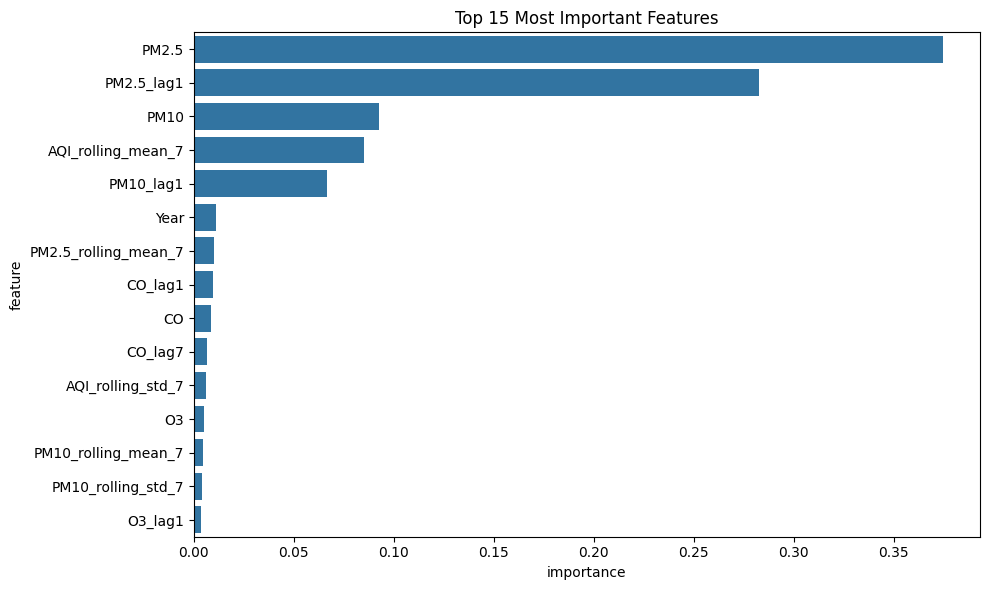

In [ ]:
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features')
plt.tight_layout()
plt.show()

**Output**: Bar plot showing the top 15 most important features according to the XGBoost model.

# **Learning Curve**

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_selected, y, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='r2'
)

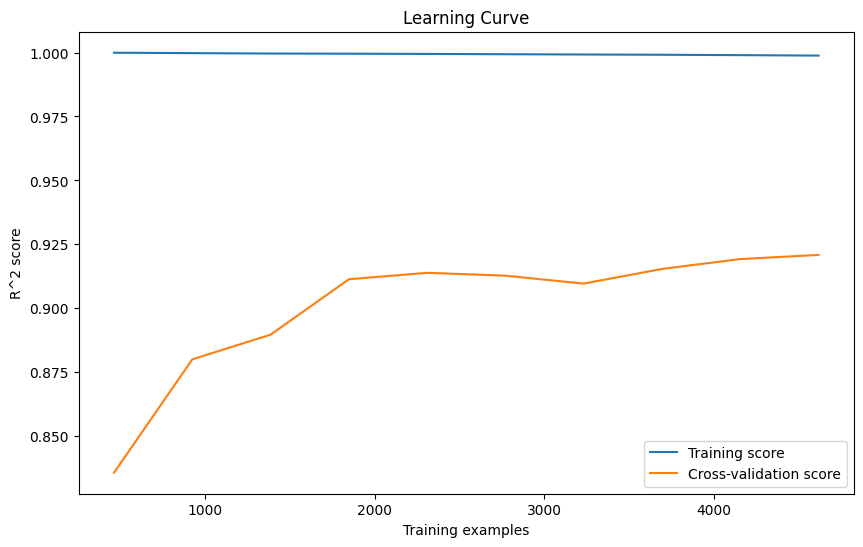


Model training and evaluation complete.


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('R^2 score')
plt.title('Learning Curve')
plt.legend()
plt.show()
print("\nModel training and evaluation complete.")

**Output**: Learning curve showing training and cross-validation scores over different training set sizes.